## Image Captioning
- Generating Captions for Images

### Steps
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("sayanf/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:14<00:00, 75.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sayanf/flickr8k/versions/5


In [ ]:
!mv  /root/.cache/kagglehub/datasets/sayanf/flickr8k/versions/5/ /content/

mv: cannot move '/root/.cache/kagglehub/datasets/sayanf/flickr8k/versions/5/' to '/content/5': Directory not empty


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM,add

In [ ]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions


In [ ]:
!ls

5		    glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip	saved
descriptions_1.txt  glove.6B.200d.txt  glove.6B.50d.txt   sample_data


In [ ]:
captions  = readTextFile("/content/5/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [ ]:
print(len(captions))

40460


In [ ]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
# Dictionary to Map each Image with the list of captions it has

In [ ]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]

    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []

    descriptions[img_name].append(second)

In [ ]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
import cv2

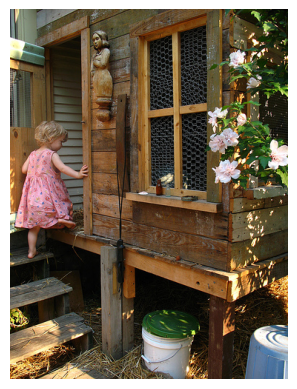

In [ ]:
IMG_PATH = "/content/5/Flickr8k_Dataset/"  # Update with your actual image path

img = cv2.imread(IMG_PATH + "1000268201_693b08cb0e.jpg")

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Could not load image from {IMG_PATH + '1000268201_693b08cb0e.jpg'}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

### Data Cleaning


In [ ]:

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()

    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence


In [ ]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [ ]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary

In [ ]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [ ]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))


Total Words 373837


In [ ]:
# Filter Words from the Vocab according to certain threshold frequncy

In [ ]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [ ]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
print(len(total_words))

1845


### Prepare Train/Test Data

In [ ]:
train_file_data = readTextFile("/content/5/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/5/Flickr8k_text/Flickr_8k.testImages.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features

### Step - 1 Image Feature Extraction

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [ ]:
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img,verbose=0)

    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06536549, 0.1678271 , 0.32518435, ..., 0.05111533, 0.32817906,
       1.0043344 ], dtype=float32)

In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)

    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)

end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
!mkdir saved

mkdir: cannot create directory ‘saved’: File exists


In [ ]:
# Store everything to the disk
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)

    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)

end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 400.96601963043213


In [ ]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-processing for Captions

In [ ]:
# Vocab
len(total_words)

1845

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [ ]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [ ]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

print(max_len)

35


### Data Loader (Generator)

## Word Embeddings

In [ ]:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-02-20 20:57:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-20 20:57:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-20 20:57:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
f = open("/content/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()

    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding


In [ ]:
f.close()

In [ ]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[idx] = embedding_vector

    return matrix



In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [ ]:
#embedding_matrix[1847]

#### Model Architecture

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 35, 50)         │         92,400 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 35, 50)         │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 35)             │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        314,368 │ dropout_3[0][0],       │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1848)           │        474,936 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,472,040 (5.62 MB)

 Trainable params: 1,472,040 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [ ]:
import tensorflow as tf # Import tensorflow

epochs = 20
number_pics_per_batch = 3
steps = 8

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                # Yielding a tuple instead of a list to match output_signature
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

# Wrap the generator with tf.data.Dataset.from_generator and specify output signature:
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch),
    output_signature=(
        (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32), tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

model.fit(dataset, epochs=epochs, steps_per_epoch=steps, verbose=1) # Fit the model using the dataset

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 7.1339
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 6.2380
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - loss: 5.7255
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - loss: 5.8111
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - loss: 5.5374
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - loss: 5.7522
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 5.6486
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - loss: 5.6147
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step - loss: 5.2110
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 5.3810
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - loss: 5.5084
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 5.3409
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 5.4901
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - loss: 5.3307
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 5.2439
Epoch 16/20
8/8 ━━━

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//20


AttributeError: 'Functional' object has no attribute 'diagram'

In [ ]:
# prompt: predict using model , for an image

def generate_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

# Example usage:
photo_path = "/content/5/Flickr8k_Dataset/1001773457_577c3a7d70.jpg" # Replace with your image path

photo = encode_image(photo_path)
photo = photo.reshape((1,2048))

caption = generate_caption(photo)
caption


'dog in the the the the the'

In [ ]:
train()

AttributeError: 'Functional' object has no attribute 'fit_generator'

In [ ]:
model = load_model('./model_weights/model_9.h5')

## Predictions

In [ ]:
def predict_caption(photo):

    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)

        if word == "endseq":
            break

    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [ ]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))

    i = plt.imread("Data/Images/"+img_name+".jpg")

    caption = predict_caption(photo_2048)
    #print(caption)

    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()


In [ ]:
#encoding_test["3385593926_d3e9c21170"].shape

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter


2025-04-26 15:50:55.741039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745682656.000038      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745682656.075491      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
images_directory = '/kaggle/input/flickr8k/Images/'
captions_path = '/kaggle/input/flickr8k/captions.txt'
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)
captions[:15:3]


['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

In [ ]:
import regex as re

In [ ]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]


['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [ ]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)


(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

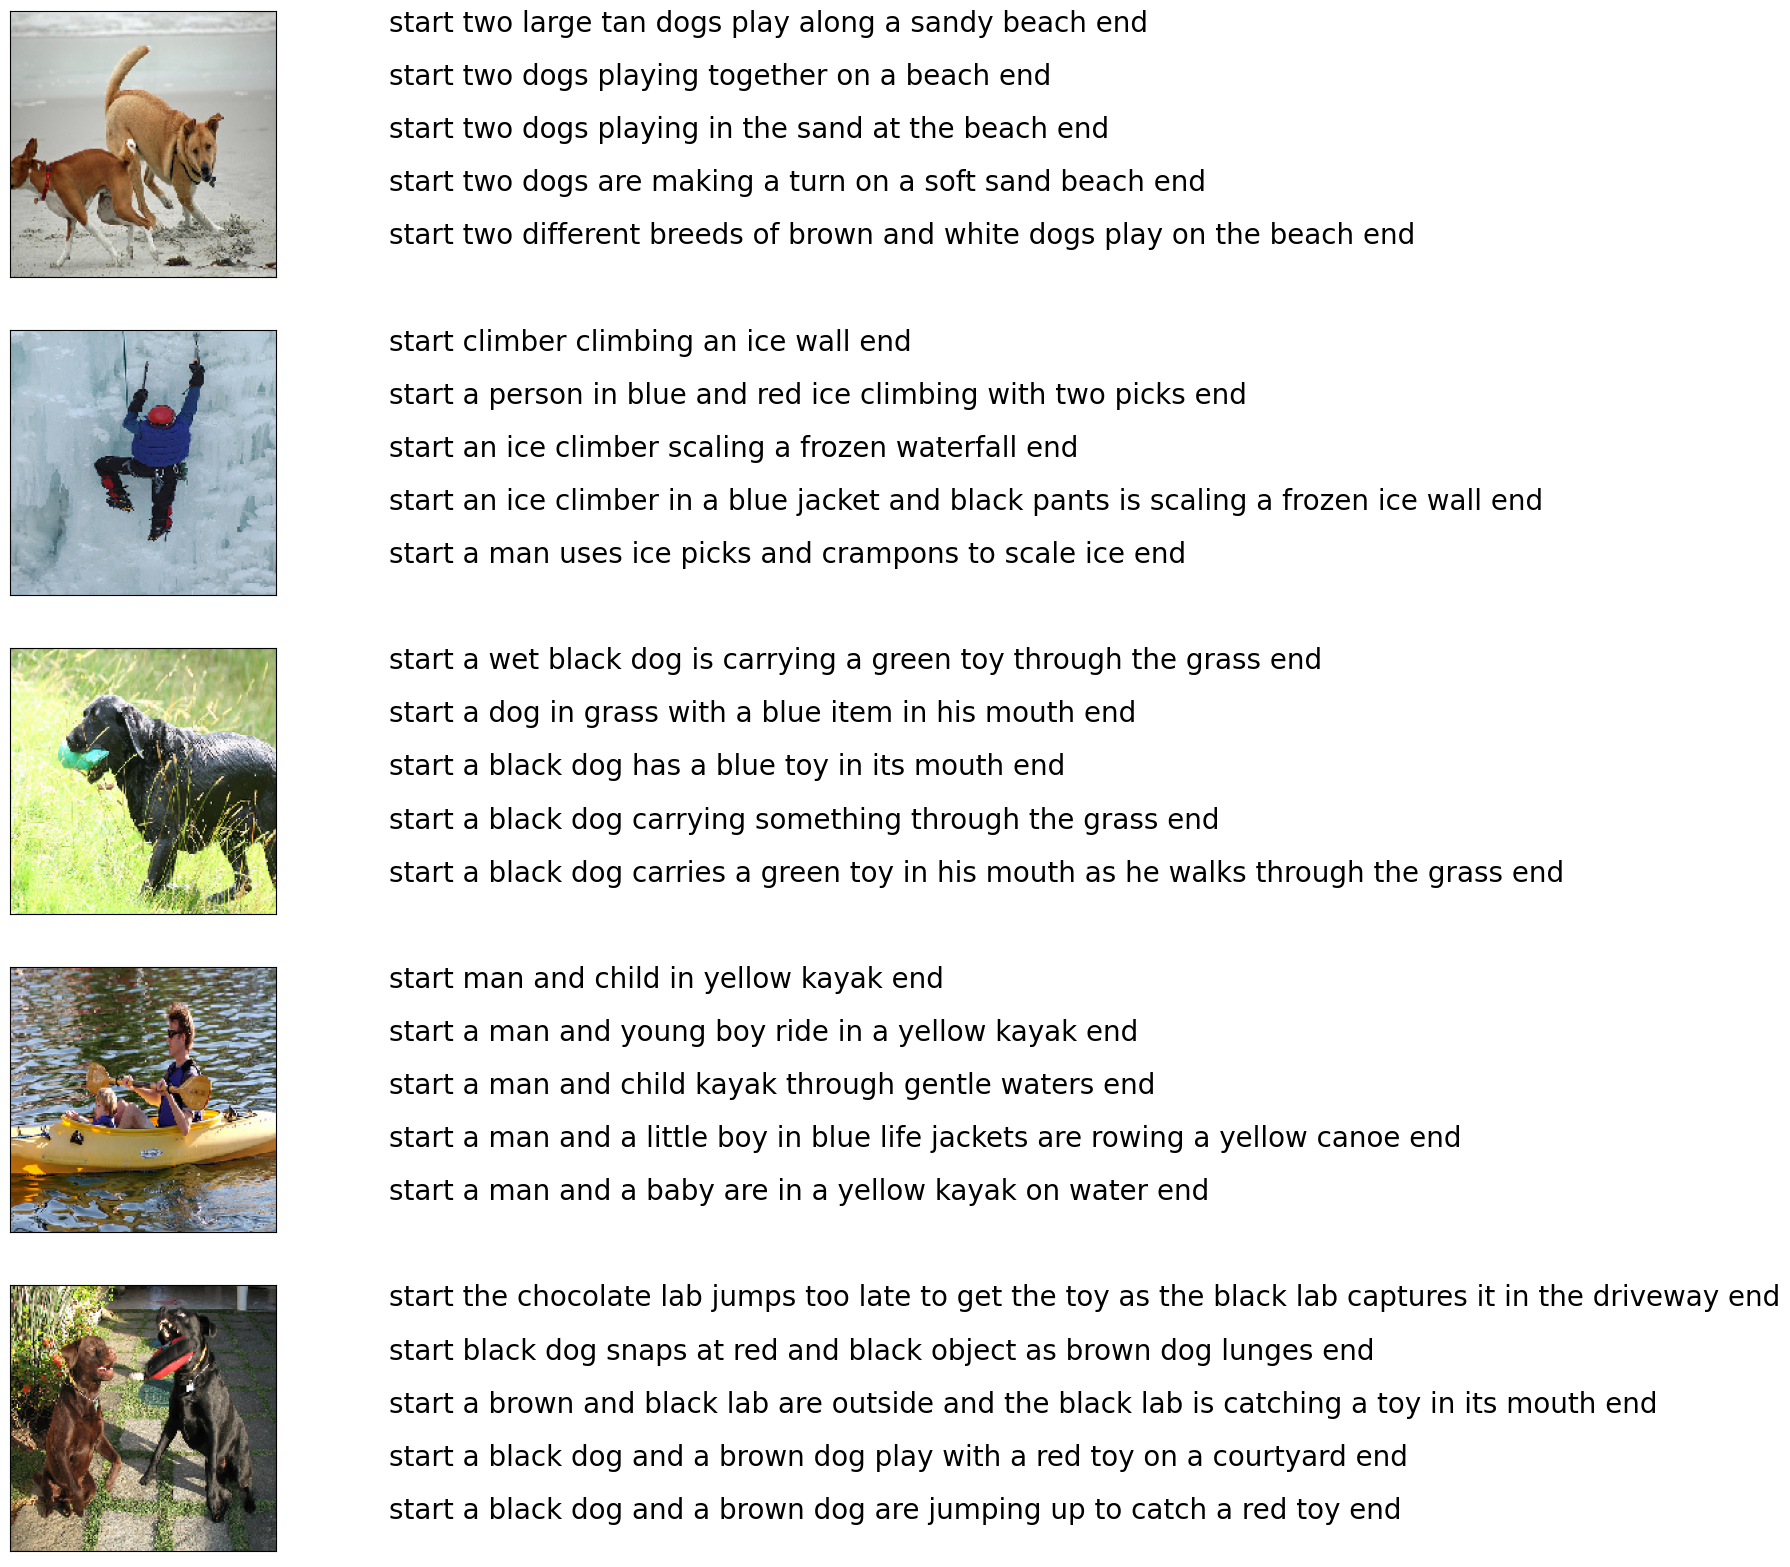

In [ ]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]

    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(captions_IDs, 5)


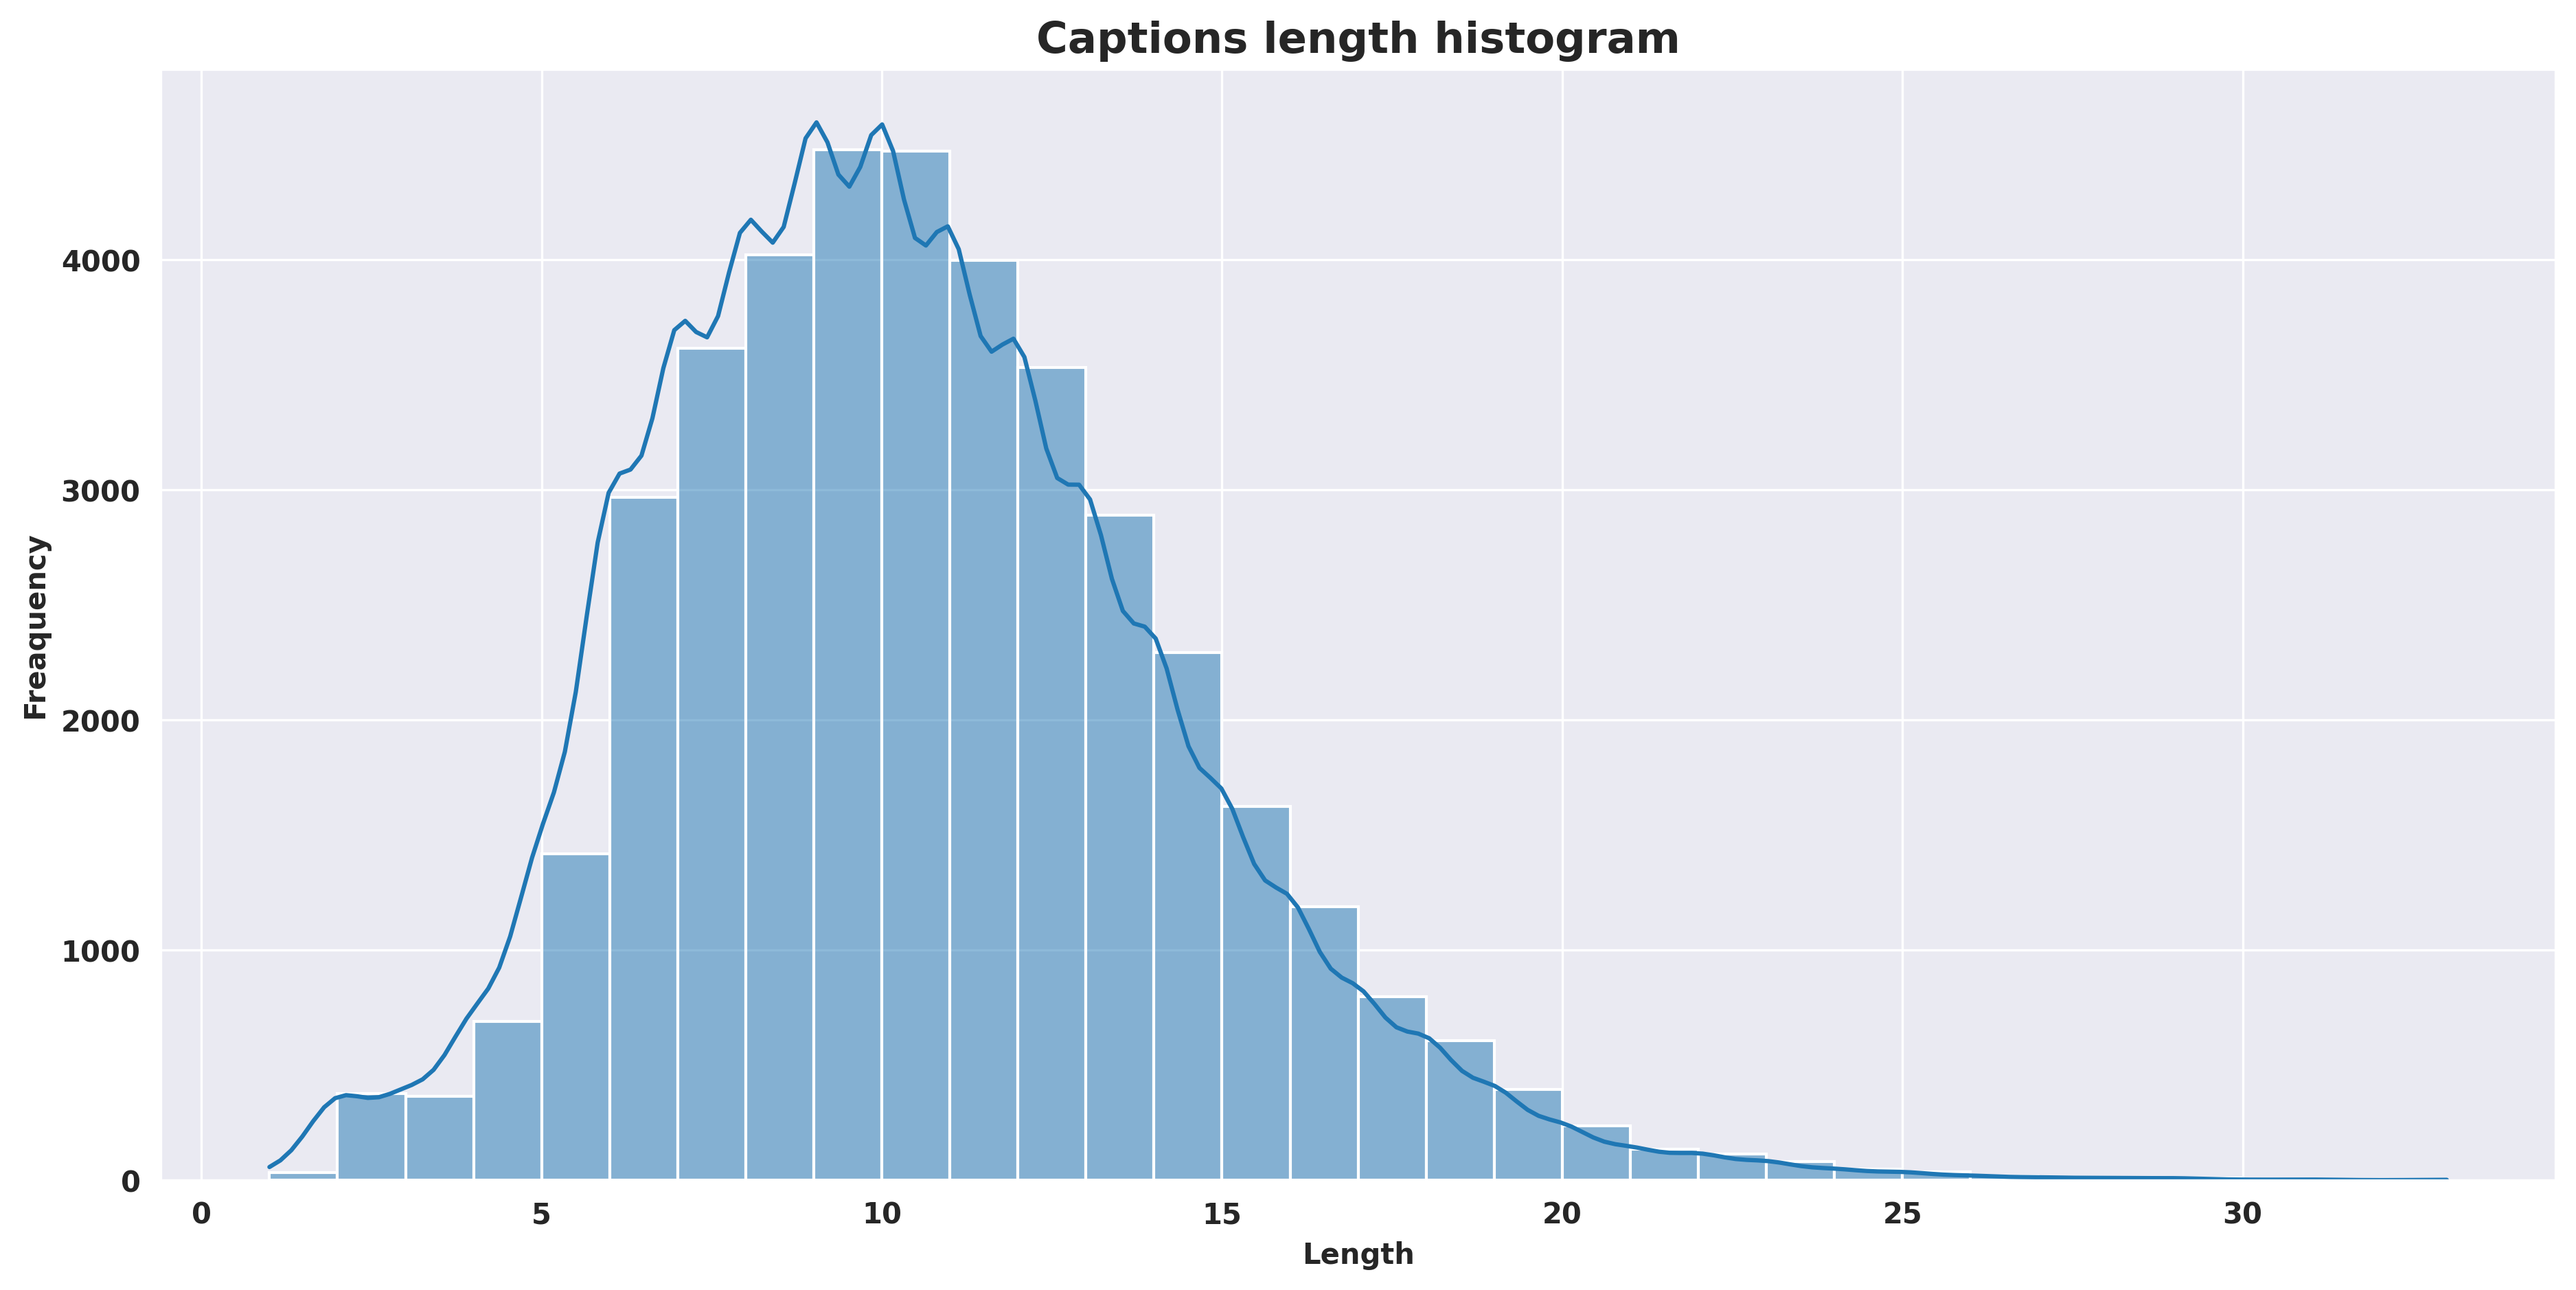

In [ ]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)


In [ ]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size


8586

In [ ]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5


('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)


2025-04-26 15:51:19.393008: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    else:
        print('Unknown image ID !')

pbar.close()


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
max_caption_length = 34
max_caption_length

34

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math  # Import math for exp

# Assuming vocab_size is defined
# vocab_size = len(tokenizer.word_index) + 1

def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0]  # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]  # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield (np.array(X_images), np.array(X_captions)), np.array(y)

# Define parameters
max_caption_length = max(len(caption.split()) for caption in train_captions) + 1
cnn_output_dim = 2048  # From inception_v3_model.output_shape[1]
batch_size_train = 270
batch_size_val = 150
vocab_size = len(tokenizer.word_index) + 1  # Ensure vocab_size is defined

In [ ]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()


Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Features_Input            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 2048)           │          8,192 │ Features_Input[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sequence_Input            │ (None, 37)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 37, 256)        │      2,198,016 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 37)             │              0 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ batch_normalization_9… │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 8586)           │      2,206,602 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

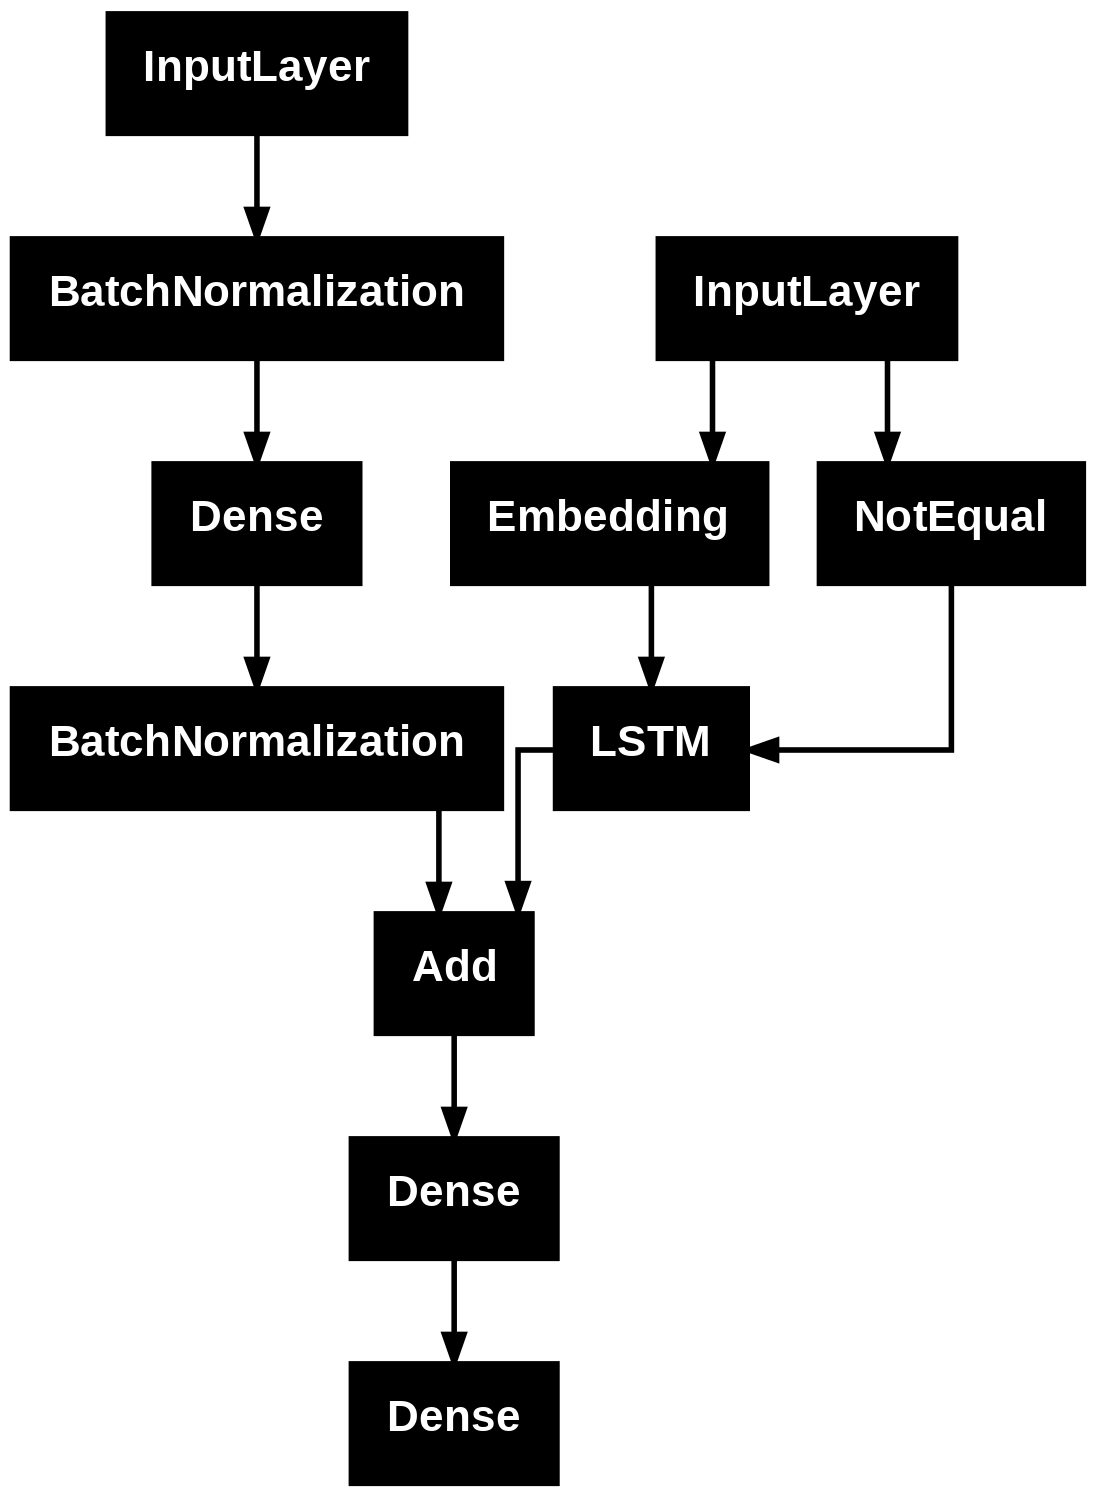

In [ ]:
plot_model(caption_model)


In [ ]:
# Define output_signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, cnn_output_dim), dtype=tf.float32),  # X_images
        tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32),  # X_captions
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y
)

# Create TensorFlow datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val),
    output_signature=output_signature
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * math.exp(-0.6)  # Use math.exp instead of tf.math.exp

lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model
history = caption_model.fit(
    train_dataset,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_dataset,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 638s 5s/step - loss: 5.1885 - val_loss: 3.7286 - learning_rate: 0.0055
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 623s 5s/step - loss: 3.3600 - val_loss: 3.3581 - learning_rate: 0.0030
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 623s 5s/step - loss: 2.9597 - val_loss: 3.2603 - learning_rate: 0.0017
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 626s 5s/step - loss: 2.7392 - val_loss: 3.2368 - learning_rate: 9.0718e-04
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 651s 5s/step - loss: 2.6077 - val_loss: 3.2224 - learning_rate: 4.9787e-04
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 651s 5s/step - loss: 2.5270 - val_loss: 3.2131 - learning_rate: 2.7324e-04
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 641s 5s/step - loss: 2.4810 - val_loss: 3.2199 - learning_rate: 1.4996e-04
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 635s 5s/step - loss: 2.4486 - val_loss: 3.2280 - learning_rate: 8.2297e-05
Epoch 9/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 636s 5s/step - loss: 2.4338 - val_loss: 3.2274 - lea

In [ ]:
# Save the entire model to a HDF5 file
caption_model.save('caption_model.h5')


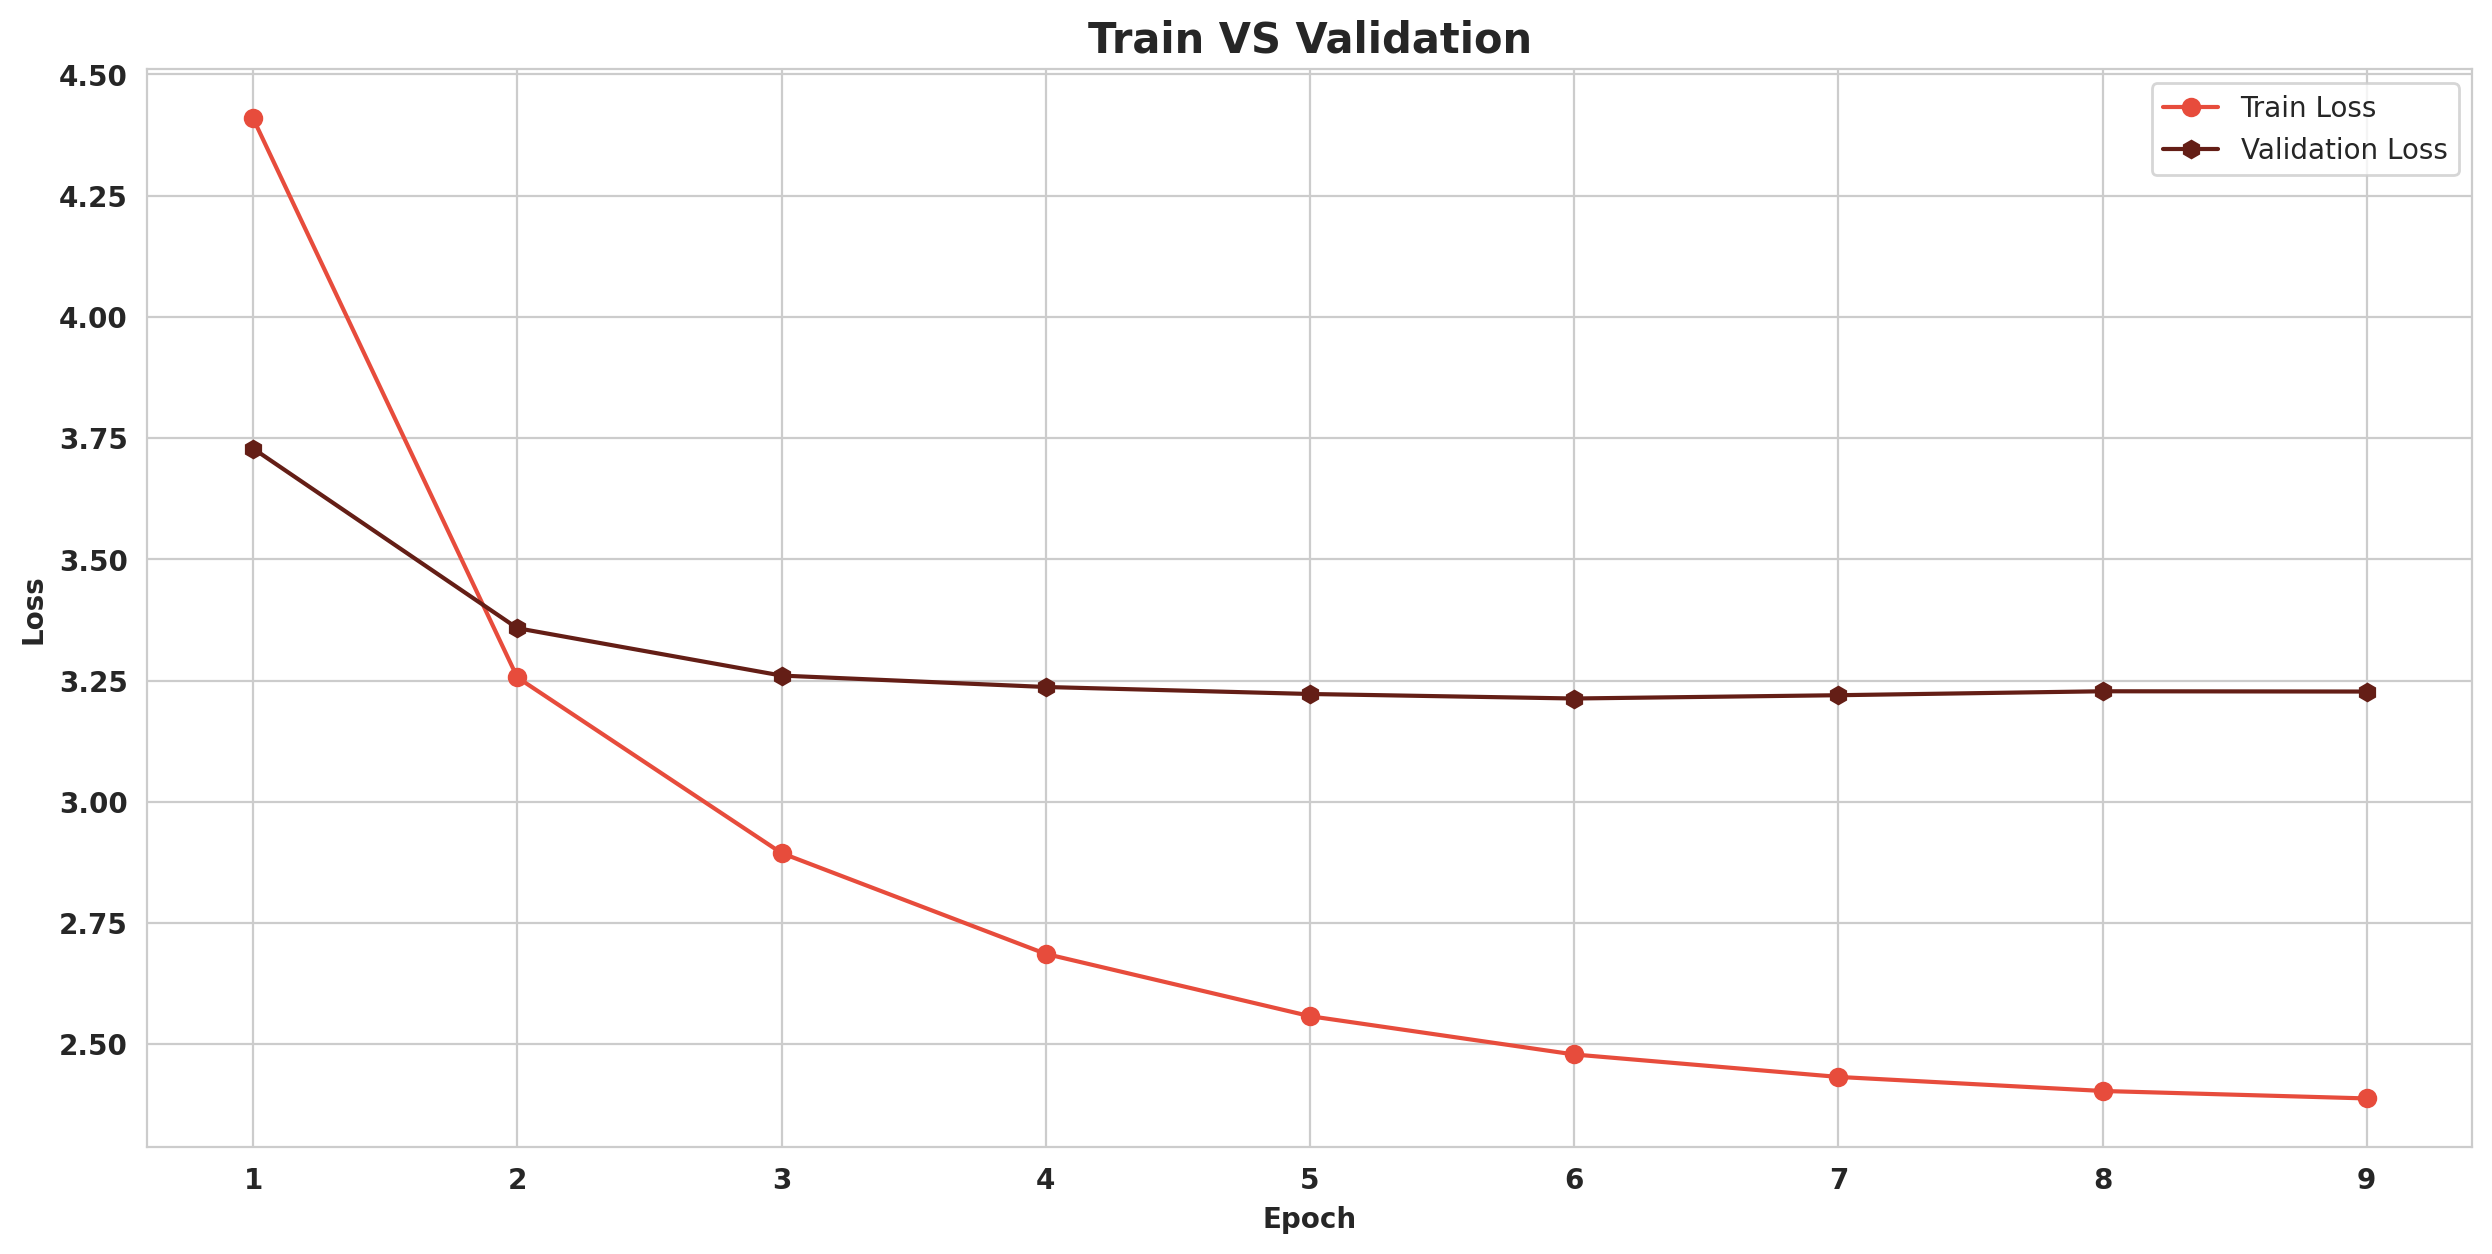

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()


In [ ]:
def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text


In [ ]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-K_beams:]

    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]
    final_caption = []
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption


In [ ]:
def BLEU_score(actual, greedy, beam_search):
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]


In [ ]:
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()


  0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
test_actual_captions = {}

pbar = tqdm_notebook(total=len(test_captions), position=0, leave=True, colour='green')  # Updated for test_captions
for caption in test_captions:
    image_id, caption_text = caption.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption_text)  # Appending caption
    pbar.update(1)

pbar.close()

  0%|          | 0/610 [00:00<?, ?it/s]

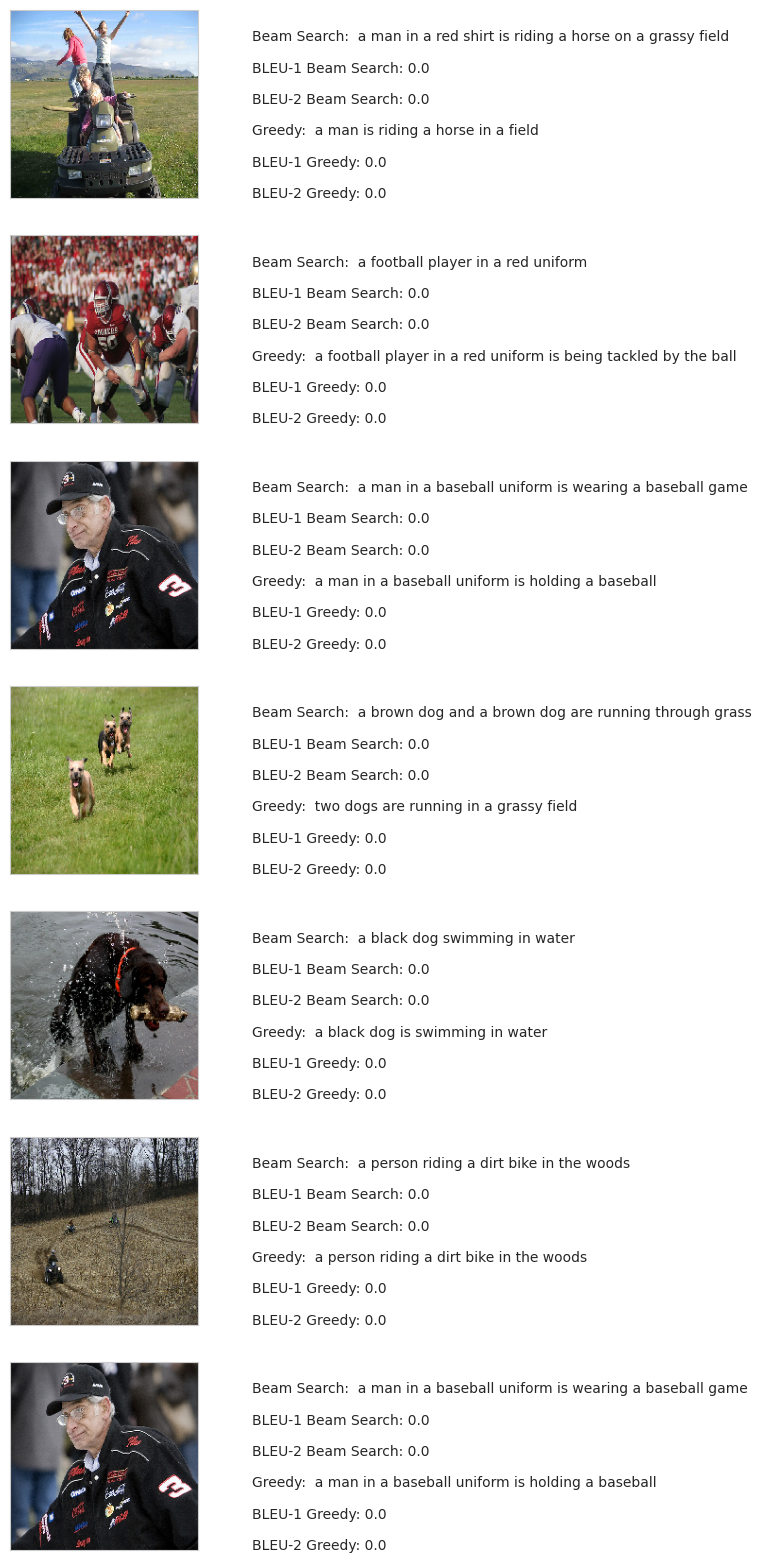

In [ ]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys())
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    count = 1
    fig = plt.figure(figsize=(6,20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap]
        actual_cap = [x.replace(" end", "") for x in actual_cap]

        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])

        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))

        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
!wget https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.istockphoto.com%2Fphotos%2Fgroup-of-teenage-boys-and-girls-dancing-at-nightclub&psig=AOvVaw0zusEdL6oHWKbtwZWAIl42&ust=1745780341236000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCNC8jN2w9owDFQAAAAAdAAAAABAT

In [ ]:
!ls

caption_model.h5  model.png


In [ ]:

# 2. Preprocess the image
image_path = '/kaggle/input/flickr8k/Images/1012212859_01547e3f17.jpg'
processed_image = preprocess_image(image_path)

# 3. Extract image features
image_features = inception_v3_model.predict(processed_image, verbose=0)
image_features = image_features.flatten()

# 4. Generate captions
greedy_caption = greedy_generator(image_features)
print("Greedy Caption:", greedy_caption)

beam_search_caption = beam_search_generator(image_features)
print("Beam Search Caption:", beam_search_caption)

Greedy Caption:  two dogs playing with a ball in the air
Beam Search Caption: two white dogs playing with a ball in the water


In [ ]:
import requests

image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTpmMGdUkQ16NxGZMuMRm2Srfjsj2TYh6MulA&s"
image_name = "fight.jpg"  # Choose a filename for the image

response = requests.get(image_url, stream=True)
response.raise_for_status()  # Raise an exception for bad responses

with open(image_name, 'wb') as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

print(f"Image downloaded as {image_name}")

Image downloaded as fight.jpg


In [ ]:

# 2. Preprocess the image
image_path = 'fight.jpg'
processed_image = preprocess_image(image_path)

# 3. Extract image features
image_features = inception_v3_model.predict(processed_image, verbose=0)
image_features = image_features.flatten()

# 4. Generate captions
greedy_caption = greedy_generator(image_features)
print("Greedy Caption:", greedy_caption)

beam_search_caption = beam_search_generator(image_features)
print("Beam Search Caption:", beam_search_caption)

Greedy Caption:  a basketball player in a white uniform is trying to catch a basketball
Beam Search Caption: a basketball player in a white uniform and black and white and white and white and white and white


Download and preprocess dataset: flickr8k

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array

In [ ]:
df = pd.read_csv("../input/flickr8k/captions.txt")
df

In [ ]:
# import re
# def caption_preprocessing(text, remove_digits=True):
#   pattern=r'[^a-zA-z0-9\s]'
#   text=re.sub(pattern,'',text)
#   # tokenize
#   text=text.split()
#   # convert to lower case
#   text = [word.lower() for word in text]
#   # remove hanging 's' and 'a'
#   # text = [word for word in text if len(word)>1]

#   # remove tokens with numbers in them
#   text = [word for word in text if word.isalpha()]
#   # store as string
#   text =  ' '.join(text)

#   # insert 'startseq', 'endseq' cho chuỗi
#   text = 'startseq ' + text + ' endseq'
#   return text

# print(caption_preprocessing('chao .. ban $ hello980 it\'s a table.#'))

In [ ]:
# df['caption'] = df['caption'].apply(caption_preprocessing)
# df['caption']

In [ ]:
# $ conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 441.4 kB/s eta 0:00:00 0:00:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5rj5rx8r
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5rj5rx8r
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=7f811284f489386213b3f478a320e5d518e6a7213cc4ec61aa5268c4680f9a1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-n62gwy5s/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import torch
import skimage.io as io
import clip
from PIL import Image
import pickle
import json
import os
from tqdm import tqdm
import argparse

In [ ]:
def parse(clip_model_type: str):
    device = torch.device('cuda:0')
    clip_model_name = clip_model_type.replace('/', '_')
    out_path = f"./oscar_split_{clip_model_name}_train.pkl"
    clip_model, preprocess = clip.load(clip_model_type, device=device, jit=False)
    all_embeddings = []
    all_captions = []
    for i in tqdm(range(len(df))):
        d=df.iloc[i]
        img_id = d["image"]
        filename = f"../input/flickr8k/Images/{img_id}"
        image = Image.open(filename).convert("RGB")
        image = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            prefix = clip_model.encode_image(image).cpu()
        d["clip_embedding"] = i
        all_embeddings.append(prefix)
        all_captions.append(d)
        if (i + 1) % 10000 == 0:
            with open(out_path, 'wb') as f:
                pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions}, f)

    with open(out_path, 'wb') as f:
        pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions}, f)

    print('Done')
    print("%0d embeddings saved " % len(all_embeddings))
    return 0


In [ ]:
clip.available_models()

In [ ]:
parse('RN50x4')

In [ ]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
# from google.colab import files
import skimage.io as io
import PIL.Image
# from IPython.display import Image
from enum import Enum


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from enum import Enum
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import os
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union


In [ ]:
class ClipCocoDataset(Dataset):

    def __len__(self) -> int:
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, ...]:
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[self.caption2embedding[item]]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

    def __init__(self, data_path: str,  prefix_length: int, gpt2_type: str = "gpt2",
                 normalize_prefix=False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        sys.stdout.flush()
        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        self.image_ids = [caption["image"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]
        if os.path.isfile(f"{data_path[:-4]}_tokens.pkl"):
            with open(f"{data_path[:-4]}_tokens.pkl", 'rb') as f:
                self.captions_tokens, self.caption2embedding, self.max_seq_len = pickle.load(f)
        else:
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0
            for caption in captions_raw:
                self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption['caption']), dtype=torch.int64))
                self.caption2embedding.append(caption["clip_embedding"])
                max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
            # self.max_seq_len = max_seq_len
            with open(f"{data_path[:-4]}_tokens.pkl", 'wb') as f:
                pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))

In [ ]:
#@title Model


class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'


class MlpTransformer(nn.Module):
     def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
         super().__init__()
         out_d = out_d if out_d is not None else in_dim
         self.fc1 = nn.Linear(in_dim, h_dim)
         self.act = act
         self.fc2 = nn.Linear(h_dim, out_d)
         self.dropout = nn.Dropout(dropout)

     def forward(self, x):
         x = self.fc1(x)
         x = self.act(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = self.dropout(x)
         return x

class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)


class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self





In [ ]:
def train(dataset: ClipCocoDataset, model: ClipCaptionModel,
          bs=64,epochs=10,save_every=5,
          lr: float = 2e-5, warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = "coco_prefix"):

    device = torch.device('cuda:0')
    batch_size = bs
    epochs = epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    # save_config(args)
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset.prefix_length - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            progress.update()
            if (idx + 1) % 10000 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                )
        progress.close()
        if epoch % save_every == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
    return model


In [ ]:
prefix_length = 40
prefix_dim = 640
mapping_type = MappingType.Transformer
data_path= './oscar_split_RN50x4_train.pkl'
only_prefix = True


In [ ]:
dataset = ClipCocoDataset(data_path, prefix_length)

In [ ]:
model=ClipCaptionPrefix(40, clip_length=40, prefix_size=640,
                        num_layers=8, mapping_type='transformer')

In [ ]:
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
train(dataset,model,
          bs=64,epochs=20,save_every=5,
          lr= 2e-5, warmup_steps = 5000, output_dir = "./", output_prefix = "coco_prefix")

# predict

In [ ]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts




In [ ]:
device = torch.device('cuda:0')
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|███████████████████████████████████████| 402M/402M [00:15<00:00, 28.1MiB/s]


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
prefix_length = 40

model = ClipCaptionPrefix(prefix_length, clip_length=40, prefix_size=640,
                                  num_layers=8, mapping_type='transformer')
model.load_state_dict(torch.load('../input/flickr8k20epoch/coco_prefix-019.pt', map_location='cpu'))

model = model.eval()
# device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

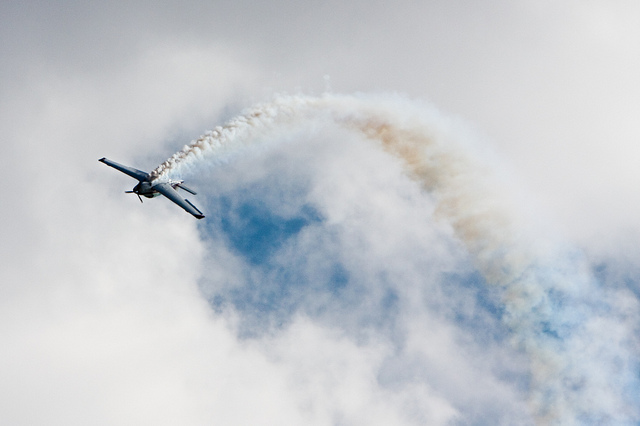

In [ ]:
images = Image.open('../input/coco-2017-dataset/coco2017/test2017/000000000647.jpg').convert("RGB")
image = preprocess(images).unsqueeze(0).to(device)
display(images)

In [ ]:
use_beam_search = True #@param {type:"boolean"}

# image = io.imread(UPLOADED_FILE)
# pil_image = PIL.Image.fromarray(image)
# #pil_img = Image(filename=UPLOADED_FILE)
# display(pil_image)

# image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix = prefix / prefix.norm(2, -1).item()
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, beam_size=7,embed=prefix_embed,stop_token='<|endoftext|>',entry_length=30)[0]


print('\n')
print(generated_text_prefix)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').




A blue and white plane is flying in midair....................
